In [3]:
import numpy as np
import pandas as pd
from fastai.vision import *

In [4]:
path = Path('/notebooks'); print(path)
data_path = path
labels = pd.read_csv('/notebooks/train_labels.csv')
work_path = path/'models'

/notebooks


In [5]:
labels.rename(columns={'id': 'name'})
labels['id']='train/'+labels['id']+'.tif'

In [6]:
data = ImageDataBunch.from_df(data_path,
                              labels,
                              #test='test',
                              ds_tfms=get_transforms(do_flip=True,
                                                    flip_vert=True,
                                                    max_lighting=0.1,
                                                    max_warp=0.),
                              size=64).normalize(imagenet_stats)

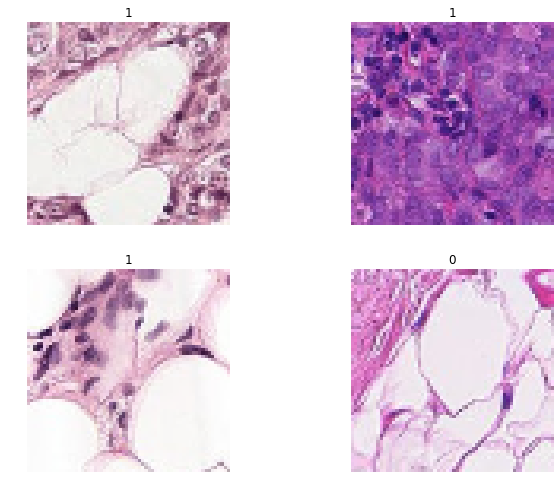

In [7]:
data.show_batch(2, figsize=(10,7))

In [8]:
def getLearner(arch, opt, loss):
    return cnn_learner(data,
                       arch,
                       opt_func = opt,
                       loss_func = loss,
                       metrics=[accuracy, AUROC()],
                       model_dir=work_path)

In [9]:
arch = models.densenet169
opt = optim.Adam
loss = nn.CrossEntropyLoss()

learn = getLearner(arch, opt, loss)

learn.fit_one_cycle(5, slice(1e-02), wd=0.01)

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/checkpoints/densenet169-b2777c0a.pth


epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.276830,0.228532,0.913692,0.967745,09:28
1,0.212199,0.167066,0.937303,0.981119,09:19
2,0.175784,0.146994,0.946142,0.985193,09:20
3,0.159846,0.131397,0.952392,0.988189,09:19
4,0.144906,0.129092,0.955028,0.988762,09:21


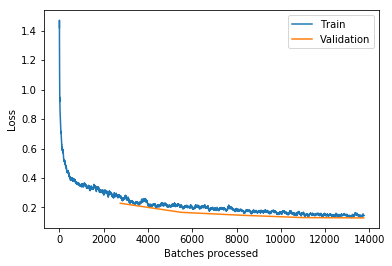

In [10]:
learn.recorder.plot_losses()

In [11]:
learn.save(work_path/'1st_training')

In [ ]:
learn.load(work_path/'1st_training')

epoch,train_loss,valid_loss,accuracy,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


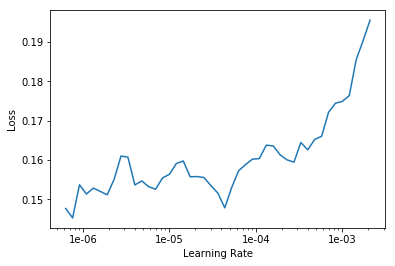

In [12]:
learn.unfreeze()

learn.lr_find(wd=0.01)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8, slice(5e-06, 1e-4), wd=0.01)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.137986,0.125880,0.954073,0.989136,12:34
1,0.163300,0.124622,0.955187,0.989427,13:10
2,0.132046,0.121671,0.956278,0.989859,13:13
3,0.127893,0.116707,0.956959,0.990651,13:12
4,0.116278,0.108907,0.960573,0.991746,13:14
5,0.108662,0.104980,0.962368,0.992234,12:58
6,0.099121,0.100489,0.963663,0.992884,13:15


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



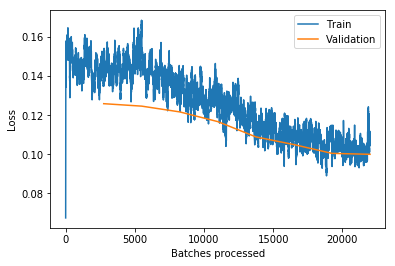

In [19]:
learn.recorder.plot_losses()

In [20]:
learn.save(work_path/'2d_training')

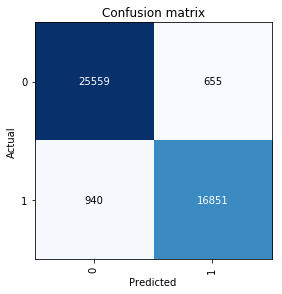

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(title='Confusion matrix')

epoch,train_loss,valid_loss,accuracy,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


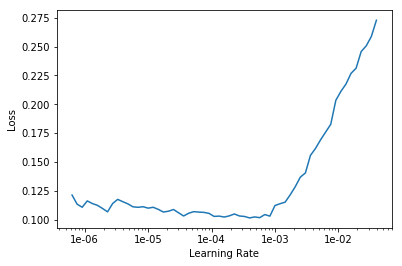

In [21]:
learn.lr_find(wd=0.01)
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(2, slice(5e-06/2, 1e-4/2), wd=0.01, moms=(0.75, 0.65))

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.099098,0.101268,0.964299,0.992794,13:12
1,0.098935,0.098760,0.965049,0.993148,13:13


In [28]:
learn.save(work_path/'3rd_training')

In [29]:
data = ImageDataBunch.from_df(data_path,
                              labels,
                              test='test',
                              ds_tfms=get_transforms(do_flip=True,
                                                    flip_vert=True,
                                                    max_lighting=0.1,
                                                    max_warp=0.),
                              size=64).normalize(imagenet_stats)

In [31]:
learn = getLearner(arch, opt, loss)
learn.load(work_path/'3rd_training')

Learner(data=ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
1,0,0,0,1
Path: /notebooks;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,1,1
Path: /notebooks;

Test: LabelList (57458 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: EmptyLabelList
,,,,
Path: /notebooks, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer

In [50]:
learn.export('model_export.pkl')

In [36]:
preds_test_tta,y_test_tta=learn.TTA(ds_type=DatasetType.Test)

In [46]:
preds_n_avg = np.zeros((len(learn.data.test_ds.items),2))
preds_n_avg = np.sum([preds_n_avg, preds_test_tta.numpy()], axis=0)

SAMPLE_SUB = '/notebooks/sample_submission.csv'
sample_df = pd.read_csv(SAMPLE_SUB)
sample_list = list(sample_df.id)

# List of tumor preds. 
# These are in the order of our test dataset and not necessarily in the same order as in sample_submission
pred_list = [p for p in preds_n_avg[:, 1]]

# To know the id's, we create a dict of id:pred
pred_dic = dict((key, value) for (key, value) in zip(learn.data.test_ds.items, pred_list))

# Now, we can create a new list with the same order as in sample_submission
pred_list_cor = [pred_dic[Path('/notebooks/test/' + id + '.tif')] for id in sample_list]

# Next, a Pandas dataframe with id and label columns.
df_sub = pd.DataFrame({'id':sample_list,'label':pred_list_cor})

# Export to csv
df_sub.to_csv('2cd_submission.csv'.format('/notebooks'), header=True, index=False)

In [48]:
df_sub.head(10)

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.026702
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.215009
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.000008
3,2c35657e312966e9294eac6841726ff3a748febf,0.018301
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.136256
5,725dabe6ecccc68b958a2c7dd75bcbf362c7cb03,0.931045
6,aa0307865281d4484ddf8c637c348292968b93a7,0.499018
7,f4e5dc9c949920f1b3362982e15e99bf6f3ef83b,0.523451
8,95e08c9cedc28a9b4a86f4fc1e06c1972134be08,0.001544
9,ee1f5345a8d4e28403b7e61b97b5f76c201ce9cb,0.149496
